# Metrics
https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch/blob/master/metric.py

['../helper', './helper', '/helper', 'helper', 'C:\\Users\\Prinzessin\\projects\\decentnet\\datasceyence\\examples', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\python39.zip', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\DLLs', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta', '', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Prinzessin\\.ipython']


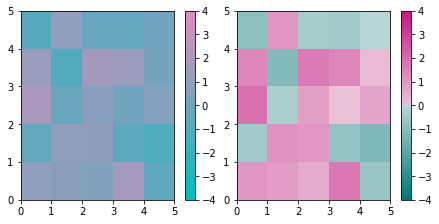

In [1]:
# unit test
import unittest

import glob

import torch
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"helper")
sys.path.insert(0, r"/helper")
sys.path.insert(0, r"./helper")
sys.path.insert(0, r"../helper")
print(sys.path)

from colour import *


from dataset.meanteacher import *

# relevant: import the UncertaintyMetric
from compute.metric.segmentation import * 
from compute.metric.symmetric_hausdorff import * 

In [2]:
# preparation
channels = 1
n_output_neurons=2
model = smp.UnetPlusPlus(
                    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
                    in_channels=channels,          # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                    classes=n_output_neurons,         # model output channels (number of classes in your dataset)
                )
csv_filenames = glob.glob(r"../data_prep/data_*_amd.csv")
# image size has to be dividable by 32!!
dataset = MeanTeacherTrainDataset(mode="train", channels=channels, image_size=512, csv_filenames=csv_filenames)
train_loader = DataLoader(dataset, batch_size=5, shuffle=True)

# relevant: create instance of class
s = SegmentationMetrics()
symhd = SymmetricHausdorffMetric()

model_output = None
# load one batch

model_output_area = []
ground_truth_area = []

for idx, item in enumerate(train_loader):
    
    print("next batch")
    
    model.eval()
    with torch.no_grad():
        model_output = model(item["img"])

        
        # item["msk"][0].permute(1, 2, 0).detach().cpu().numpy()
        model_output_noise = model_output * item["msk"]
        
        for msk, pred in zip(item["msk"], model_output_noise):
            
            print("pred", pred.shape)
            print("msk", msk.shape)
            
            _, highest_class = torch.max(pred, 1)  
            
            print("high", highest_class.shape)

            model_output_area.append(torch.sum(highest_class))

            ground_truth_area.append(torch.sum(msk))

    

    if idx == 2:
        break




next batch
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
next batch
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
next batch
pred torch.Size([2, 512, 512])
msk torch.Size([1, 512, 512])
high torch.Size([2, 512])
pred torch

In [3]:
# model_output_noise = model_output * item["msk"]

#print(model_output)

from scipy.spatial.distance import directed_hausdorff
    
print(s(y_true=item["msk"], y_pred=model_output_noise))
print(symhd(model_output_noise, item["msk"]))

{'acc': 1.0000000035149386, 'fscore': 0.0044290978573407885, 'prec': 1.0, 'rec': 0.00221946404427523, 'jac': 0.00221946404427523}
2.134066171703483


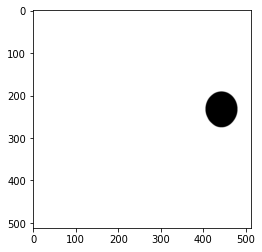

In [4]:
plt.figure()
plt.imshow( item["msk"][0].permute(1, 2, 0).detach().cpu().numpy(), cmap="gray" )



torch.Size([5, 2, 512, 512])
torch.Size([5, 512, 512])
torch.Size([512, 512])


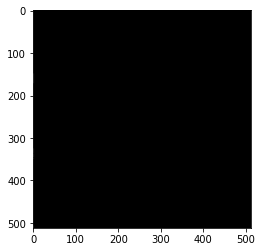

In [10]:
print(model_output.shape)

_, highest_class = torch.max(model_output_noise, 1)   
# highest_class = highest_class.detach().cpu().numpy()

print(highest_class.shape)

#redo = highest_class.permute(1, 2, 0)
print(highest_class[0].shape)

plt.figure()
plt.imshow(highest_class[0], cmap="gray")
plt.show()

In [6]:
o = model_output_area.copy()
g = ground_truth_area.copy()

[tensor(30742.0938), tensor(27126.8438), tensor(8700.9844), tensor(46207.8438), tensor(16064.7500), tensor(19866.1562), tensor(37164.4375), tensor(15132.7344), tensor(25309.4688), tensor(21373.2031), tensor(3436.5469), tensor(21803.2500), tensor(33788.1250), tensor(51141.), tensor(47195.6562), tensor(309472), tensor(51578.6641), tensor(51578.6641), 250000, tensor(193420.)]


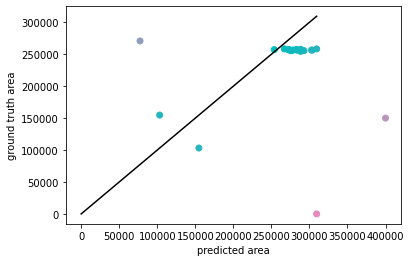

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_output_area = o.copy()
ground_truth_area = g.copy()

max_num = max(max(model_output_area), max(ground_truth_area))

if False:
    model_output_area.append(0)
    ground_truth_area.append(0)
    model_output_area.append(max_num)
    ground_truth_area.append(max_num)
    model_output_area.append(max_num)
    ground_truth_area.append(0)
    model_output_area.append(0)
    ground_truth_area.append(max_num)
    
    ground_truth_area = ground_truth_area[:-4]
    model_output_area = model_output_area[:-4]

ground_truth_area.append(0)
model_output_area.append(max_num)
ground_truth_area.append(max_num/2)
model_output_area.append(max_num/3)
ground_truth_area.append(max_num/3)
model_output_area.append(max_num/2)

ground_truth_area.append(150000)
model_output_area.append(400000)

ground_truth_area.append(max_num-max_num/8)
model_output_area.append(max_num/8+max_num/8)
    
c = [np.abs(ele1-ele2) for ele1, ele2 in zip(model_output_area, ground_truth_area)]

print(c)


plt.figure()
plt.xlabel("predicted area")
plt.ylabel("ground truth area")
plt.scatter(model_output_area, ground_truth_area, c=c, cmap=variint_map3, vmin=0, vmax=max_num)
plt.plot([0, max_num], [0, max_num], color = 'k')

plt.savefig("example_results/area.png", dpi=1200)

